In [13]:
import torch
import sys
sys.path.insert(0,'..')
from copg_optim import CoPG
from torch.distributions import Categorical
import numpy as np
from matchingpennies.matching_pennies import pennies_game
from matchingpennies.network import policy1, policy2

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

## Competitive Policy Gradient

In [14]:
# Initialize policy for both agents for rock paper scissors
p1 = policy1() 
p2 = policy2()
for p in p1.parameters():
    print(p)
for p in p2.parameters():
    print(p)

Parameter containing:
tensor([0.9000, 0.1000], requires_grad=True)
Parameter containing:
tensor([0.2000, 0.9000], requires_grad=True)


In [15]:
# Initialisation of CPG and game environement
optim = CoPG(p1.parameters(),p2.parameters(), lr =0.5)
env = pennies_game()

In [16]:
num_episode = 120
batch_size = 1000

<IPython.core.display.Javascript object>


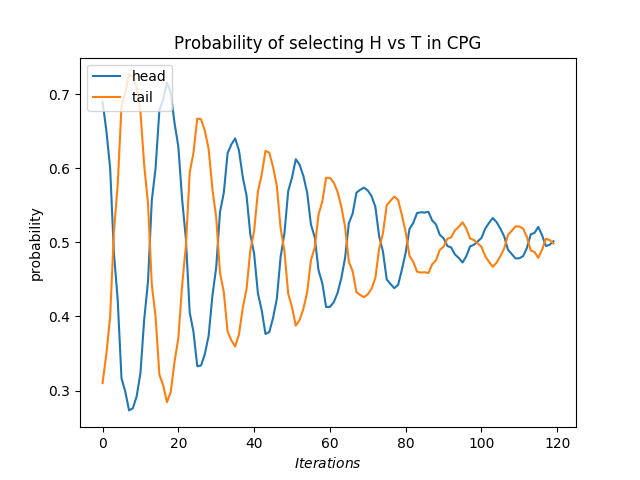

In [17]:
### Competitive Policy gradient
p1 = policy1() 
p2 = policy2()
# Initialisation of CPG and game environement
optim = CoPG(p1.parameters(),p2.parameters(), lr =0.5)
env = pennies_game()

mat_head = []
mat_tail = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for t_eps in range(num_episode):
    mat_action = []
    mat_state1 = []
    mat_reward1 = []
    mat_done = []
    mat_state2 = []
    mat_reward2 = []
    state, _, _, _, _ = env.reset()
    
    #data_collection
    for i in range(batch_size):
        pi1 = p1()
        dist1 = Categorical(pi1)
        action1 = dist1.sample()

        pi2 = p2()
        dist2 = Categorical(pi2)
        action2 = dist2.sample()
        action = np.array([action1, action2])

        state = np.array([0,0])
        mat_state1.append(torch.FloatTensor(state))
        mat_state2.append(torch.FloatTensor(state))
        mat_action.append(torch.FloatTensor(action))

        state, reward1, reward2, done, _ = env.step(action)
        mat_reward1.append(torch.FloatTensor([reward1]))
        mat_reward2.append(torch.FloatTensor([reward2]))
        mat_done.append(torch.FloatTensor([1 - done]))

    action_both = torch.stack(mat_action)

    val1_p = torch.stack(mat_reward1).transpose(0,1)
    if val1_p.size(0)!=1:
        raise 'error'

    pi_a1_s = p1()
    dist_pi1 = Categorical(pi_a1_s)
    action_both = torch.stack(mat_action)
    log_probs1 = dist_pi1.log_prob(action_both[:,0])

    pi_a2_s = p2()
    dist_pi2 = Categorical(pi_a2_s)
    log_probs2 = dist_pi2.log_prob(action_both[:,1])

    objective = log_probs1*log_probs2*(val1_p)
    if objective.size(0)!=1:
        raise 'error'
        
#     if t_eps%100 ==0:
#         print('p1', pi1.data[0],pi1.data[1])
#         print('p2', pi2.data[0],pi2.data[1])
    
    mat_head.append(pi1.data[0])
    mat_tail.append(pi1.data[1])

    ob = objective.mean()

    s_log_probs1 = log_probs1.clone() # otherwise it doesn't change values
    s_log_probs2 = log_probs2.clone()
    
    for i in range(1,log_probs1.size(0)):
        s_log_probs1[i] = torch.add(s_log_probs1[i - 1],log_probs1[i])
        s_log_probs2[i] = torch.add(s_log_probs2[i - 1], log_probs2[i])
    
    objective2 = s_log_probs1*log_probs2*(val1_p)
    ob2 = objective2.mean()
    
    objective3 = log_probs1*s_log_probs2*(val1_p)
    ob3 = objective3.mean()
    
    lp1 = log_probs1*val1_p
    lp1=lp1.mean()
    lp2 = log_probs2*val1_p
    lp2=lp2.mean()
    optim.zero_grad()

    optim.step(ob, lp1,lp2) # for horizon 1, ob2 and ob3 will not have influence

    ax.clear()
    plt.title('Probability of selecting H vs T in CPG')
    plt.xlabel('$Iterations$')
    plt.ylabel('probability')
    ax.plot(np.array(mat_head), label='head')
    ax.plot(np.array(mat_tail), label='tail')
    plt.legend(loc='upper left')
    fig.canvas.draw()

## Gradient Descent Ascent

In [11]:
p1 = policy1()
p2 = policy2()
for p in p1.parameters():
    print(p)
for p in p2.parameters():
    print(p)

Parameter containing:
tensor([0.9000, 0.1000], requires_grad=True)
Parameter containing:
tensor([0.2000, 0.9000], requires_grad=True)


<IPython.core.display.Javascript object>


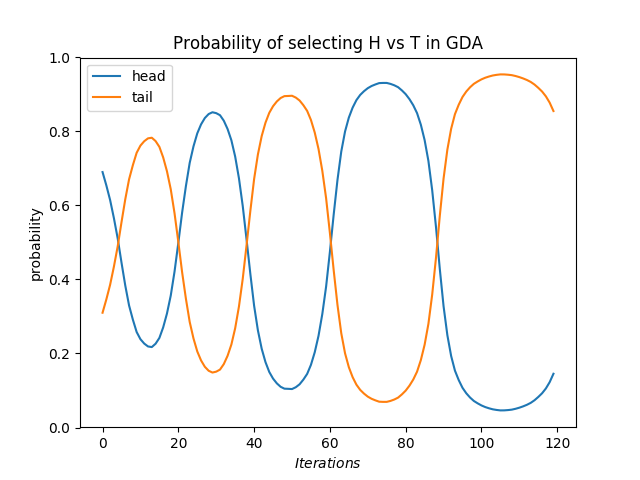

In [12]:
### Gradient descent ascent
p1 = policy1() 
p2 = policy2()
optim_p1 = torch.optim.SGD(p1.parameters(), lr=0.5)
optim_p2 = torch.optim.SGD(p2.parameters(), lr=0.5)
env = pennies_game()

mat_head = []
mat_tail = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for t_eps in range(num_episode):
    mat_action = []
    mat_state1 = []
    mat_reward1 = []
    mat_done = []
    mat_state2 = []
    mat_reward2 = []
    state, _, _, _, _ = env.reset()
    
    #data_collection
    for i in range(batch_size):
        pi1 = p1()
        dist1 = Categorical(pi1)
        action1 = dist1.sample()

        pi2 = p2()
        dist2 = Categorical(pi2)
        action2 = dist2.sample()
        action = np.array([action1, action2])

        state = np.array([0,0])
        mat_state1.append(torch.FloatTensor(state))
        mat_state2.append(torch.FloatTensor(state))
        mat_action.append(torch.FloatTensor(action))

        state, reward1, reward2, done, _ = env.step(action)
        mat_reward1.append(torch.FloatTensor([reward1]))
        mat_reward2.append(torch.FloatTensor([reward2]))
        mat_done.append(torch.FloatTensor([1 - done]))

    action_both = torch.stack(mat_action)

    val1_p = torch.stack(mat_reward1).transpose(0,1)

    if val1_p.size(0)!=1:
        raise 'error'

    pi_a1_s = p1()
    dist_pi1 = Categorical(pi_a1_s)
    action_both = torch.stack(mat_action)
    log_probs1 = dist_pi1.log_prob(action_both[:,0])

    objective = -log_probs1 * (val1_p)
    ob = objective.mean()
    optim_p1.zero_grad()
    ob.backward()
    optim_p1.step()

    val2_p = -val1_p
    pi_a2_s = p2()
    dist_pi2 = Categorical(pi_a2_s)
    log_probs2 = dist_pi2.log_prob(action_both[:,1])

    objective2 = -log_probs2 * (val2_p)
    optim_p2.zero_grad()
    ob2 = objective2.mean()
    ob2.backward()
    optim_p2.step()
    
    mat_head.append(pi1.data[0])
    mat_tail.append(pi1.data[1])
    
    ax.clear()
    plt.title('Probability of selecting H vs T in GDA')
    plt.xlabel('$Iterations$')
    plt.ylabel('probability')
    ax.plot(np.array(mat_head), label='head')
    ax.plot(np.array(mat_tail), label='tail')
    plt.legend(loc='upper left')
    fig.canvas.draw()